# Dependencies

In [1]:
import os
import sys

sys.path.append(os.getcwd().split('notebooks')[0])

from notebooks.utilities.utils import *

Device: cpu


In [2]:
import time
import random
# import wandb
import numpy as np
from dotmap import DotMap
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader

import sys
from notebooks.utilities.helper_functions import *

from notebooks.tensor_completion_models.CoSTCo import *
from notebooks.tensor_completion_models.CPD import *
from notebooks.tensor_completion_models.tuckER import *
from notebooks.tensor_completion_models.ETC import *

import matplotlib.pyplot as plt
from sklearn.utils.validation import check_random_state
import tensorly as tl
from torch.nn.init import xavier_normal_

from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split, KFold

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cpu


# Load Tensor

### Preliminaries

In [4]:
original_tensor = None
for_queries = False
file = None

### Query Tensors

In [5]:
# file = "AND_AND_801"
# file = "AND_OR_801"
# file = "OR_AND_801"
# file = "OR_OR_801"

# file = "AND_AND_distinct_817"
# file = "AND_OR_distinct_817"
# file = "OR_AND_distinct_817"
# file = "OR_OR_distinct_817"


if (file is not None):
    file = 'query_tensors/' + file
    original_tensor = torch.load(f"{meta_data_folder}{file}.pt")

In [6]:
if (original_tensor is not None):
    original_tensor = (original_tensor - original_tensor.min())/(original_tensor.max() - original_tensor.min())
    for_queries = True

### Hyperparameter Tensors

In [7]:
# file = "non_deep/SVM_Dermatology_828"           # trivial but CoSTCo still slightly better than naive
# file = "non_deep/RF_Dermatology_828"            # good one
# file = "non_deep/ET_Dermatology_828"            # good one
# file = "non_deep/DT_Dermatology_828"
file = "non_deep/KNN_car_evaluation_828"        # pretty good one (~ 4000 cells too)
# file = "non_deep/DT_Spambase_829"               # good one
# file = "non_deep/RF_Spambase_829"               # good one
# file = "non_deep/ET_Spambase_829"               # good one
# file = "non_deep/GB_Spambase_829"               # good one
# file = "non_deep/KNN_Spambase_829"              # trivial but CoSTCo still slightly better than naive

# file = "non_deep/SVM_Biodeg_905"                # pretty decent
# file = "non_deep/SVM_Dermatology_905"           # great !
# file = "non_deep/SVM_Alzheimers_905"              

# file = "non_deep/KNN_Alzheimers_902"            # good one
# file = "non_deep/KNN_Glass_902"                 # eh
# file = "non_deep/KNN_Dermatology_903"           # bad

In [8]:
# original_tensor = torch.stack((torch.load(f"{meta_data_folder}non_deep/DT_Spambase_829.pt"),
#                                torch.load(f"{meta_data_folder}non_deep/RF_Spambase_829.pt"),
#                                torch.load(f"{meta_data_folder}non_deep/ET_Spambase_829.pt"),
#                                torch.load(f"{meta_data_folder}non_deep/GB_Spambase_829.pt")))

# original_tensor = original_tensor[:, :, 0, :, :, :].clone()          # very good one

### Deep Learning Tensors

In [9]:
# file = "deep_learning/FCNN_biodeg_828"              # maybe... (CoSTCo is barely better than naive median)
# file = "deep_learning/FCNN_Dermatology_829"         # good one
# file = "deep_learning/FCNN_glass_902"               # maybe... (CoSTCo is barely better than naive median)

# file = "deep_learning/FCNN_Spambase_902"            # eh
# file = "deep_learning/FCNN_Particle_ID_903_02"      # decent !
# file = "deep_learning/FCNN_Alzheimers_902"          # bad
# file = "deep_learning/FCNN_car_evaluation_903"      # pretty decent
# file = "deep_learning/FCNN_Dermatology_903"         # interesting (good way)

# file = "deep_learning/FCNN_Spambase_905_50"

In [10]:
# original_tensor = torch.stack((torch.load(f"{meta_data_folder}deep_learning/FCNN_Spambase_902.pt"),
#                                torch.load(f"{meta_data_folder}deep_learning/FCNN_Particle_ID_903_02.pt"),
#                                torch.load(f"{meta_data_folder}deep_learning/FCNN_Alzheimers_902.pt"),
#                                torch.load(f"{meta_data_folder}deep_learning/FCNN_car_evaluation_903.pt"),
#                                torch.load(f"{meta_data_folder}deep_learning/FCNN_Dermatology_903.pt")))
# # very nice !

In [11]:
if (file is not None): 
    
    if (original_tensor is None): 
        original_tensor = torch.load(f"{meta_data_folder}{file}.pt")
    
    file = file.split('/')[-1]
    print(f"File Name: {file}")

File Name: KNN_car_evaluation_828


### Looking at Tensor

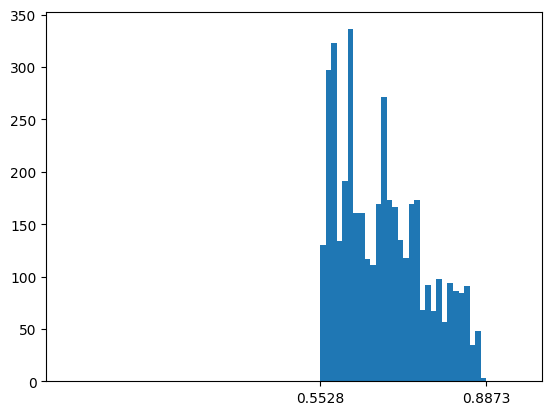

In [12]:
plt.hist([float(x) for x in original_tensor.flatten()], bins = 30)
plt.xlim(0, 1)
plt.xticks([original_tensor.min(), original_tensor.max()])
plt.show()

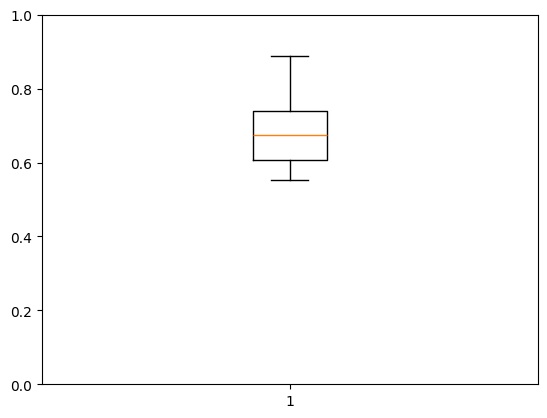

In [13]:
plt.boxplot([float(x) for x in original_tensor.flatten()])
plt.ylim(0, 1)
plt.show()

In [14]:
original_tensor.shape

torch.Size([3, 7, 2, 9, 11])

In [15]:
print(f"Tensor shape: {original_tensor.shape}")
total_cells = 1
for s in original_tensor.shape: total_cells*=s

print(f"{total_cells} total cells in tensor.")

Tensor shape: torch.Size([3, 7, 2, 9, 11])
4158 total cells in tensor.


# Train & Evaluate

### Some Training Configurations

In [16]:
num_epochs = 10000
batch_size = 256
lr = 5e-3
wd = 1e-4
val_size = 0.2

num_iterations = 5

portions = [0.01, 0.025, 0.05, 0.1]

### Make Portion Graphs

##### Function

In [17]:
all_times = list()

for portion in portions:

        it_times = list()
        
        print(f"Portion {portion} iteration:", end = " ")
        for it in range(1, num_iterations+1):
                
                sparse_tensor = get_sparse_tensor(t = original_tensor.clone(),
                                                portion = portion,
                                                verbose = False)
                
                        
                model_times = list()
                
# _________________________________________________________________________________________________________________________________________________________________

                
                start_time = time.time()
                
                model = train_tensor_completion(model_type = 'cpd.smooth',
                                                sparse_tensor = sparse_tensor,
                                                rank = 3,
                                                num_epochs = num_epochs,
                                                batch_size = batch_size,
                                                lr = lr,
                                                wd = wd,
                                                early_stopping = True,
                                                flags = 15,
                                                val_size = 0.2,
                                                convert_to_cpd = False,
                                                for_queries = for_queries,
                                                device = device)
                
                
                s = get_unique_MAE(model = model,
                                   full_t = original_tensor.clone(),
                                   sparse_t = sparse_tensor.clone(),
                                   return_errors = False,
                                   return_indices = False,
                                   device = device)
                
                
                model_times += [time.time() - start_time]
                
                del model, s, start_time

# _________________________________________________________________________________________________________________________________________________________________
                
                start_time = time.time()
                
                model = train_tensor_completion(model_type = 'costco',
                                                sparse_tensor = sparse_tensor,
                                                rank = 32,
                                                num_epochs = num_epochs,
                                                batch_size = batch_size,
                                                lr = lr,
                                                wd = wd,
                                                early_stopping = True,
                                                flags = 15,
                                                val_size = 0.2,
                                                convert_to_cpd = False,
                                                for_queries = for_queries,
                                                device = device)
                
                
                s = get_unique_MAE(model = model,
                                   full_t = original_tensor.clone(),
                                   sparse_t = sparse_tensor.clone(),
                                   return_errors = False,
                                   return_indices = False,
                                   device = device)
                
                
                model_times += [time.time() - start_time]
                
                del model, s, start_time
                

# _________________________________________________________________________________________________________________________________________________________________
                
                start_time = time.time()                
                
                model = ETC(sparse_tensor = sparse_tensor,
                        models_type_rank = [
                                        'cpd.smooth_1', 'cpd.smooth_3', 'cpd.smooth_5', 'cpd.smooth_10'
                                        ],
                        
                        num_splits = 10,
                        mlp_hidden_dim1 = 128,
                        agg_func = 'mlp',
                        dropout_p = 0.0,
                        dropout_p_before_mlp = 0.0,
                        lr = lr,
                        wd = wd,
                        num_epochs = num_epochs,
                        batch_size = batch_size,
                        for_queries = for_queries,
                        device = device)
                
                p_time = (time.time() - start_time)/4
                
                del start_time
                
                start_time = time.time()                          
                
                model = train_learned_ensemble(model = model,
                                                sparse_tensor = sparse_tensor,
                                                lr = lr,
                                                wd = wd,
                                                num_epochs = num_epochs,
                                                batch_size = batch_size,
                                                flags = 50,
                                                early_stopping = True,
                                                val_size = 0.2,
                                                device = device)
                
                
                s = get_unique_MAE(model = model,
                                   full_t = original_tensor.clone(),
                                   sparse_t = sparse_tensor.clone(),
                                   return_errors = False,
                                   return_indices = False,
                                   device = device)
                
                
                model_times += [(time.time() - start_time) + p_time]
                
                del model, s, start_time

# _________________________________________________________________________________________________________________________________________________________________

                it_times +=[model_times]

                if (it == num_iterations): print(it)
                else: print(it, end = ", ")

        all_times += [it_times]

all_times = np.array(all_times)

print("\nAll done!")

Portion 0.01 iteration: 1, 2, 3, 4, 5
Portion 0.025 iteration: 1, 2, 3, 4, 5
Portion 0.05 iteration: 1, 2, 3, 4, 5
Portion 0.1 iteration: 1, 2, 3, 4, 5

All done!


In [18]:
labels = ['CPD-S', 'CoSTCo', 'CPD-S Ensemble']

In [19]:
avgs = all_times.mean(axis = 1)
stds = all_times.std(axis = 1)

In [20]:
df = list()

for i in range(avgs.shape[0]):
    row = list()
    for j in range(avgs.shape[1]):
        
        row += [f"{avgs[i, j]:.3f} $\pm$ {stds[i, j]:.2f}"]
        
    df += [row]

In [21]:
print(pd.DataFrame(np.array(df)).to_latex(index = False))

\begin{tabular}{lll}
\toprule
0 & 1 & 2 \\
\midrule
0.635 $\pm$ 0.29 & 0.447 $\pm$ 0.07 & 0.737 $\pm$ 0.20 \\
1.835 $\pm$ 1.48 & 1.113 $\pm$ 0.12 & 2.346 $\pm$ 1.06 \\
2.836 $\pm$ 1.33 & 6.143 $\pm$ 3.10 & 2.612 $\pm$ 0.25 \\
1.133 $\pm$ 0.10 & 116.460 $\pm$ 4.79 & 1.479 $\pm$ 0.11 \\
\bottomrule
\end{tabular}

